SA on game comments

model: TFIDF (max_features=20000) + random forest (or XGboost or Adaboost whatsoever)

Load the whole dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from pathlib import Path
import random

random.seed(13)

dataset_heartless_path = Path('../../dataset/sa/dataset_cleaned_heartless.pkl').resolve()

dataset = pd.read_pickle(dataset_heartless_path)
# dataset = dataset.sample(frac=p)      # no sampling is needed

# convert the text to string object
dataset['review_text'] = dataset['review_text'].astype('str')

# drop any duplicate just in case
dataset = dataset.drop_duplicates(keep='first')

# replace -1 to 0
# then 0 = negative, 1 = positive
# for easier processing
dataset['review_score'] = dataset['review_score'].replace(-1, 0)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4891928 entries, 0 to 4891927
Data columns (total 6 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   index         int64 
 1   app_id        int64 
 2   app_name      object
 3   review_text   object
 4   review_score  int64 
 5   review_votes  int64 
dtypes: int64(4), object(2)
memory usage: 223.9+ MB


In [2]:
dataset['review_text'] = dataset['review_text'].astype('str')

In [3]:
dataset = dataset.drop_duplicates(keep='first')

In [4]:
# remove rows have all whitespaces
dataset['num_of_words'] = dataset['review_text'].apply(lambda x:len(str(x).split()))
dataset = dataset[dataset['num_of_words'] > 0]

In [5]:
# remove number of rows that have less than N number of characters

character_limit = 20

dataset = dataset[dataset['review_text'].str.len()>=character_limit]

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4626526 entries, 1 to 4891927
Data columns (total 7 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   index         int64 
 1   app_id        int64 
 2   app_name      object
 3   review_text   object
 4   review_score  int64 
 5   review_votes  int64 
 6   num_of_words  int64 
dtypes: int64(5), object(2)
memory usage: 282.4+ MB


Data cleaning

This is customized to each model, as each model has their own limitation to the dataset

No rows will be removed in this step

In [7]:
import re
import nltk

In [8]:
def clean(raw):
    """ Remove hyperlinks and markup """
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result)
    result = re.sub('&#x27;', "'", result)
    result = re.sub('&quot;', '"', result)
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result)
    result = re.sub('</i>', '', result)
    result = re.sub('&#62;', '', result)
    result = re.sub('<i>', ' ', result)
    result = re.sub("\n", '', result)
    return result

In [9]:
def remove_num(texts):
   output = re.sub(r'\d+', '', texts)
   return output

In [10]:
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

In [11]:
def unify_whitespaces(x):
    cleaned_string = re.sub(' +', ' ', x)
    return cleaned_string 

In [12]:
def remove_symbols(x):
    cleaned_string = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', x)
    return cleaned_string

In [13]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"',','))
    return final

In [14]:
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
# nltk.download('stopwords')
from nltk.stem import PorterStemmer

stop=set(stopwords.words("english"))
stemmer=PorterStemmer()
lemma=WordNetLemmatizer()

def remove_stopword(text):
   text=[word.lower() for word in text.split() if word.lower() not in stop]
   return " ".join(text)

In [15]:
from nltk.stem import SnowballStemmer

snowball_stemmer = SnowballStemmer('english')

def stemming(text):
   stem=[]
   # stopword = stopwords.words('english')
   word_tokens = nltk.word_tokenize(text)
   stemmed_word = [snowball_stemmer.stem(word) for word in word_tokens]
   stem=' '.join(stemmed_word)
   return stem

In [16]:
def cleaning(df,review):
    df[review] = df[review].apply(clean)
    df[review] = df[review].apply(deEmojify)
    df[review] = df[review].str.lower()
    df[review] = df[review].apply(remove_num)
    df[review] = df[review].apply(remove_symbols)
    df[review] = df[review].apply(remove_punctuation)
    df[review] = df[review].apply(remove_stopword)
    df[review] = df[review].apply(unify_whitespaces)
    df[review] = df[review].apply(stemming)

In [17]:
def cleaning_arr(str_arr):
    str_arr = str_arr.apply(lambda x: clean(x))
    str_arr = str_arr.apply(lambda x: deEmojify(x))
    str_arr = str_arr.apply(lambda x: x.lower())
    str_arr = str_arr.apply(lambda x: remove_num(x))
    str_arr = str_arr.apply(lambda x: remove_symbols(x))
    str_arr = str_arr.apply(lambda x: remove_punctuation(x))
    str_arr = str_arr.apply(lambda x: remove_stopword(x))
    str_arr = str_arr.apply(lambda x: unify_whitespaces(x))
    str_arr = str_arr.apply(lambda x: stemming(x))

    return str_arr

In [18]:
def cleaning_pyarr(str_arr):
    str_arr = list(map(clean, str_arr))
    str_arr = list(map(deEmojify, str_arr))
    str_arr = list(map(str.lower, str_arr))
    str_arr = list(map(remove_num, str_arr))
    str_arr = list(map(remove_symbols, str_arr))
    str_arr = list(map(remove_punctuation, str_arr))
    str_arr = list(map(remove_stopword, str_arr))
    str_arr = list(map(unify_whitespaces, str_arr))
    str_arr = list(map(stemming, str_arr))

    return str_arr

Run all functions require 18 min

In [19]:
# cleaning(dataset,'review_text')

In [20]:
temp = dataset.groupby('review_score').count()['review_text'].reset_index().sort_values(by='review_score',ascending=True)
temp.style.background_gradient(cmap='Purples')

,review_score,review_text
0,0,753364
1,1,3873162


Create train-test and validation set

In [21]:
# define constants

VALIDATION_RATIO = 0.2      # ratio of validation set to whole ~4.8M dataset
TEST_RATIO = 0.2            # ratio of test set to the whole train-test dataset

In [22]:
X = dataset['review_text']
y = dataset['review_score']

In [23]:
from sklearn.model_selection import train_test_split

X_train_test, X_valid, y_train_test, y_valid = train_test_split(X, y, random_state=42, test_size=VALIDATION_RATIO)

In [24]:
print(len(X_valid))
print(len(y_valid))
print(len(X_train_test))
print(len(y_train_test))

print()
print()

print('validation set')
print(y_valid.value_counts())
print()
print('train-test set')
print(y_train_test.value_counts())

925306
925306
3701220
3701220


validation set
review_score
1    774937
0    150369
Name: count, dtype: int64

train-test set
review_score
1    3098225
0     602995
Name: count, dtype: int64


Then we create a (roughly) balanced dataset for training and testing

In [25]:
from imblearn.under_sampling import RandomUnderSampler

# X_train, X_test, y_train, y_test

# oversampling = RandomOverSampler(sampling_strategy=0.5)     # raise the ratio minority_data:majority_data as 1 (i.e. equal number of samples)
under = RandomUnderSampler(sampling_strategy=1.0, random_state=13)          # then select ? of it

# X_train_resampled, y_train_resampled = oversampling.fit_resample(X_train.to_numpy().reshape(-1, 1), y_train.to_numpy().reshape(-1, 1))
# X_train_resampled, y_train_resampled = under.fit_resample(X_train_resampled, y_train_resampled)

X_train_test_resampled, y_train_test_resampled = under.fit_resample(X_train_test.to_numpy().reshape(-1, 1), y_train_test.to_numpy().reshape(-1, 1))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train_test_resampled,
    y_train_test_resampled,
    random_state=13,
    test_size=TEST_RATIO)

In [27]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

print()
print()

# distribution of +ve and -ve comments in train and test set
import collections

print('training set')
print(collections.Counter(y_train))
print()
print('testing set')
print(collections.Counter(y_test))

964792
964792
241198
241198


training set
Counter({0: 482670, 1: 482122})

testing set
Counter({1: 120873, 0: 120325})


apply cleaning before further creating a subset of comments for training data

In [28]:
X_valid = cleaning_arr(X_valid)

In [29]:
X_valid

2493049                                       expert game ok
1827314    big map short stori wast money dlc wild run ad...
3119303    gon na leav bedroom door open tonight aint typ...
648090     review endless space pros relat easi learn com...
3736585    dev anyth throw dlc unfinish game go buy damn ...
                                 ...                        
2605736    game like play movi captiv start till finish a...
1394373    know game multi player would nice mention desc...
3110643                            wtfi cant regist game one
4407650                                  best coop game ever
2946958    confus honest love game playdead insid brillia...
Name: review_text, Length: 925306, dtype: object

In [30]:
X_train = cleaning_pyarr(list(X_train.ravel()))
X_train = np.array(X_train)

In [31]:
X_test = cleaning_pyarr(list(X_test.ravel()))
X_test = np.array(X_test)

After splitting, we need to limit the number of rows of data (for consistency across different models, due to training time, and other factors)

Avaliable options: 50K, 100K, 200K comments in each class [positive, negative]

Selected: 100K first :D

In [32]:
NO_OF_COMMENTS_TRAINING_PER_CLASS = 100 * 1000

In [33]:
# create dataset

# what we can do is to shuffle then select first N comments as sample
rng_1 = np.random.default_rng(seed=42)
rng_2 = np.random.default_rng(seed=13)

indices_pos = np.where(y_train == 1)[0]
indices_neg = np.where(y_train == 0)[0]

rng_1.shuffle(indices_pos)
rng_2.shuffle(indices_neg)

indices_all = np.concatenate((indices_neg[:NO_OF_COMMENTS_TRAINING_PER_CLASS], indices_pos[:NO_OF_COMMENTS_TRAINING_PER_CLASS]), axis=None)

# shuffle once more
rng = np.random.default_rng()
rng.shuffle(indices_all)

X_train_subset = X_train[indices_all]
y_train_subset = y_train[indices_all]

In [34]:
print(len(X_train_subset))
print(len(y_train_subset))
print()
print()
print('training set')
print(collections.Counter(y_train_subset))
print()

200000
200000


training set
Counter({1: 100000, 0: 100000})



: 

Build the model and pipeline

In [35]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier

In [36]:
# TODO: can do sth on the max_features
# e.g. selecting words that appear more than N times in the training set

from collections import Counter

words_counter = Counter([s for sublist in list(X_train) for s in sublist.split()])

In [37]:
print("Total number of discrete words:", len(words_counter.items()))
print()
for n in [5000, 1000, 500, 100, 50, 25, 10]:
    print("Number of words with count >= {}: {}".format(n, len(Counter({k:c for k,c in words_counter.items() if c >= n}))))

# len(Counter({k:c for k,c in words_counter.items() if c >= 100}))

Total number of discrete words: 244361

Number of words with count >= 5000: 1143
Number of words with count >= 1000: 3017
Number of words with count >= 500: 4309
Number of words with count >= 100: 9513
Number of words with count >= 50: 13361
Number of words with count >= 25: 18896
Number of words with count >= 10: 30629


In [38]:
temp2 = pd.DataFrame(words_counter.items())
temp2.columns = ['Common_words','count']
temp2.style.background_gradient(cmap='Blues')
temp2['count'].describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])

count    2.443610e+05
mean     1.447661e+02
std      4.723735e+03
min      1.000000e+00
1%       1.000000e+00
10%      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      3.000000e+00
90%      1.500000e+01
99%      1.432400e+03
max      1.862839e+06
Name: count, dtype: float64

In [39]:
# vect = CountVectorizer(stop_words="english", max_features=5000)
vect = CountVectorizer(stop_words="english", max_features=20000)
tfidf = TfidfTransformer()
model = RandomForestClassifier()

In [40]:
# we first create features through count vectorizer over training set
# we then use this vectorizer and apply to the test set (.transform() only)
X_train_subset_vectorized = vect.fit_transform(X_train_subset.ravel())

In [41]:
print(X_train_subset_vectorized.shape)
print()
print()
print(vect.get_feature_names_out())

(200000, 20000)


['aa' 'aaa' 'aaaaand' ... 'zz' 'zzz' 'zzzz']


In [42]:
pipeline_train = Pipeline([
    ('tfidf', tfidf),
    ('model', model)
])

In [43]:
sa_classifier = pipeline_train.fit(X_train_subset_vectorized, y_train_subset)

Save the models

In [58]:
from datetime import datetime
import pickle

filename = Path('sa_tfidf-rf-20000_model_{}.sav'.format(datetime.today().strftime("%Y-%m-%d")))
pickle.dump(model, open(filename, 'wb'))

filename = Path('sa_tfidf-rf-20000_count-vectorizer_{}.pkl'.format(datetime.today().strftime("%Y-%m-%d")))
pickle.dump(vect, open(filename, 'wb'))

filename = Path('sa_tfidf-rf-20000_tfidf_{}.pkl'.format(datetime.today().strftime("%Y-%m-%d")))
pickle.dump(tfidf, open(filename, 'wb'))

: 

---

Load the models (optional)

In [45]:
from datetime import datetime
import pickle

models_date = datetime(2023, 12, 12)

filename = Path('sa_tfidf-rf-20000_model_{}.sav'.format(models_date.strftime("%Y-%m-%d")))
model = pickle.load(open(filename, 'rb'))

filename = Path('sa_tfidf-rf-20000_count-vectorizer_{}.pkl'.format(models_date.strftime("%Y-%m-%d")))
vect = pickle.load(open(filename, 'rb'))

filename = Path('sa_tfidf-rf-20000_tfidf_{}.pkl'.format(datetime.today().strftime("%Y-%m-%d")))
tfidf = pickle.load(open(filename, 'rb'))

Evaluation

In [46]:
pipeline_test = Pipeline([
    ('vect', vect),
    ('tfidf', tfidf),
    ('model', model),
])

In [47]:
y_test_pred_prob_raw = pipeline_test.predict_proba(X_test.ravel())

y_test_pred = np.argmax(y_test_pred_prob_raw, axis=1)

# creating single class label probability for ploting ROC curve
y_test_pred_prob = y_test_pred_prob_raw if len(np.unique(y_test)) > 2 \
                else np.array([y_test_pred_prob_raw[i, pred] for i, pred in enumerate(list(y_test_pred))])

In [48]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

def print_classification_report(y_true,y_pred):
    cfmat = confusion_matrix(y_true,y_pred)
    print('Classification report: \n',classification_report(y_true,y_pred))
    print("\n")
    print('TN - True Negative {}'.format(cfmat[0,0]))
    print('FN - False Negative {}'.format(cfmat[1,0]))
    print('TP - True Positive {}'.format(cfmat[1,1]))
    print('FP - False Positive {}'.format(cfmat[0,1]))
    print('Accuracy Rate: {}'.format(np.divide(np.sum([cfmat[0,0],cfmat[1,1]]),np.sum(cfmat))))
    print('Misclassification Rate: {}'.format(np.divide(np.sum([cfmat[0,1],cfmat[1,0]]),np.sum(cfmat))))
    print('F1-Score: {}'.format(f1_score(y_true, y_pred,average='macro')))
    print('ROC-AUC {}'.format(roc_auc_score(y_true,y_pred)))

In [49]:
print_classification_report(y_test,y_test_pred)

Classification report: 
               precision    recall  f1-score   support

           0       0.80      0.85      0.82    120325
           1       0.84      0.79      0.82    120873

    accuracy                           0.82    241198
   macro avg       0.82      0.82      0.82    241198
weighted avg       0.82      0.82      0.82    241198



TN - True Negative 101800
FN - False Negative 24822
TP - True Positive 96051
FP - False Positive 18525
Accuracy Rate: 0.820284579474125
Misclassification Rate: 0.179715420525875
F1-Score: 0.8201824221859202
ROC-AUC 0.8203429674094987


In [50]:
def create_confusion_matrix_graph(y_true, y_pred, title=None, save=False, save_filename=None):

    # pre checking
    if save and save_filename == None:
        print("save_filename camnot be empty, function exits.")
        return


    ax = sns.heatmap(confusion_matrix(y_true,y_pred),annot=True,fmt='')

    ax.set_title(title)
    ax.set_xlabel("predicted label")
    ax.set_ylabel('true label')
    ax.set_xticklabels(['[0]\nNegative', '[1]\nPositive'])
    ax.set_yticklabels(['Negative [0]', 'Positive [1]'])

    if save:
        plt.savefig(save_filename, dpi=600, faccecolor='w')

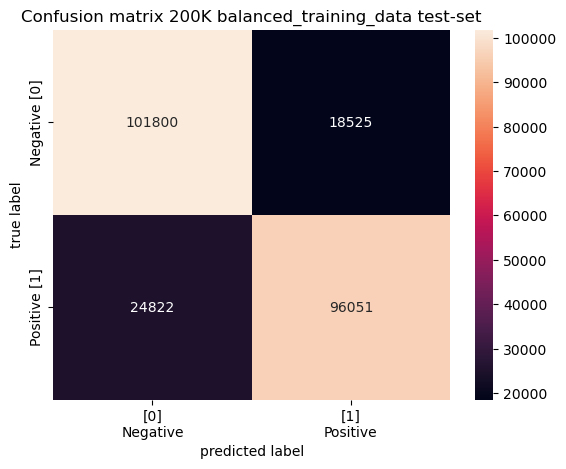

In [51]:
create_confusion_matrix_graph(y_test, y_test_pred, 'Confusion matrix 200K balanced_training_data test-set', False)

In [52]:
# plot ROC curve for binary class classification

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve_binary(y_test, y_pred, title=None, save=False, save_filename=None):

    # pre-checking
    if save and save_filename == None:
        print('save_filename cannot be empty. Function exits.')
        return


    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(2):
        fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
        roc_auc[i] = auc(fpr[i], tpr[i])

    print(roc_auc_score(y_test, y_pred))
    plt.figure(dpi=600)
    plt.plot(fpr[1], tpr[1], label="ROC curve (area = {:0.4f})".format(roc_auc_score(y_test, y_pred)))

    # random-guess line
    plt.plot([0, 1], [0, 1], "k--")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title if title else 'Receiver operating characteristic (ROC)')
    plt.legend(loc='lower right')

    # if save:
    #     plt.savefig(f'steam-games-reviews-analysis-sentiment-analysis_ROC-curve_{datetime.now().strftime("%Y%m%d%H%M%S")}.png', dpi=600, facecolor='w')

    # plt.show() should come AFTER than plt.savefig
    # as plt.show() clears the whole thing -> anything after wards will happen on a new blank figure
    plt.show()

0.5108236388363856


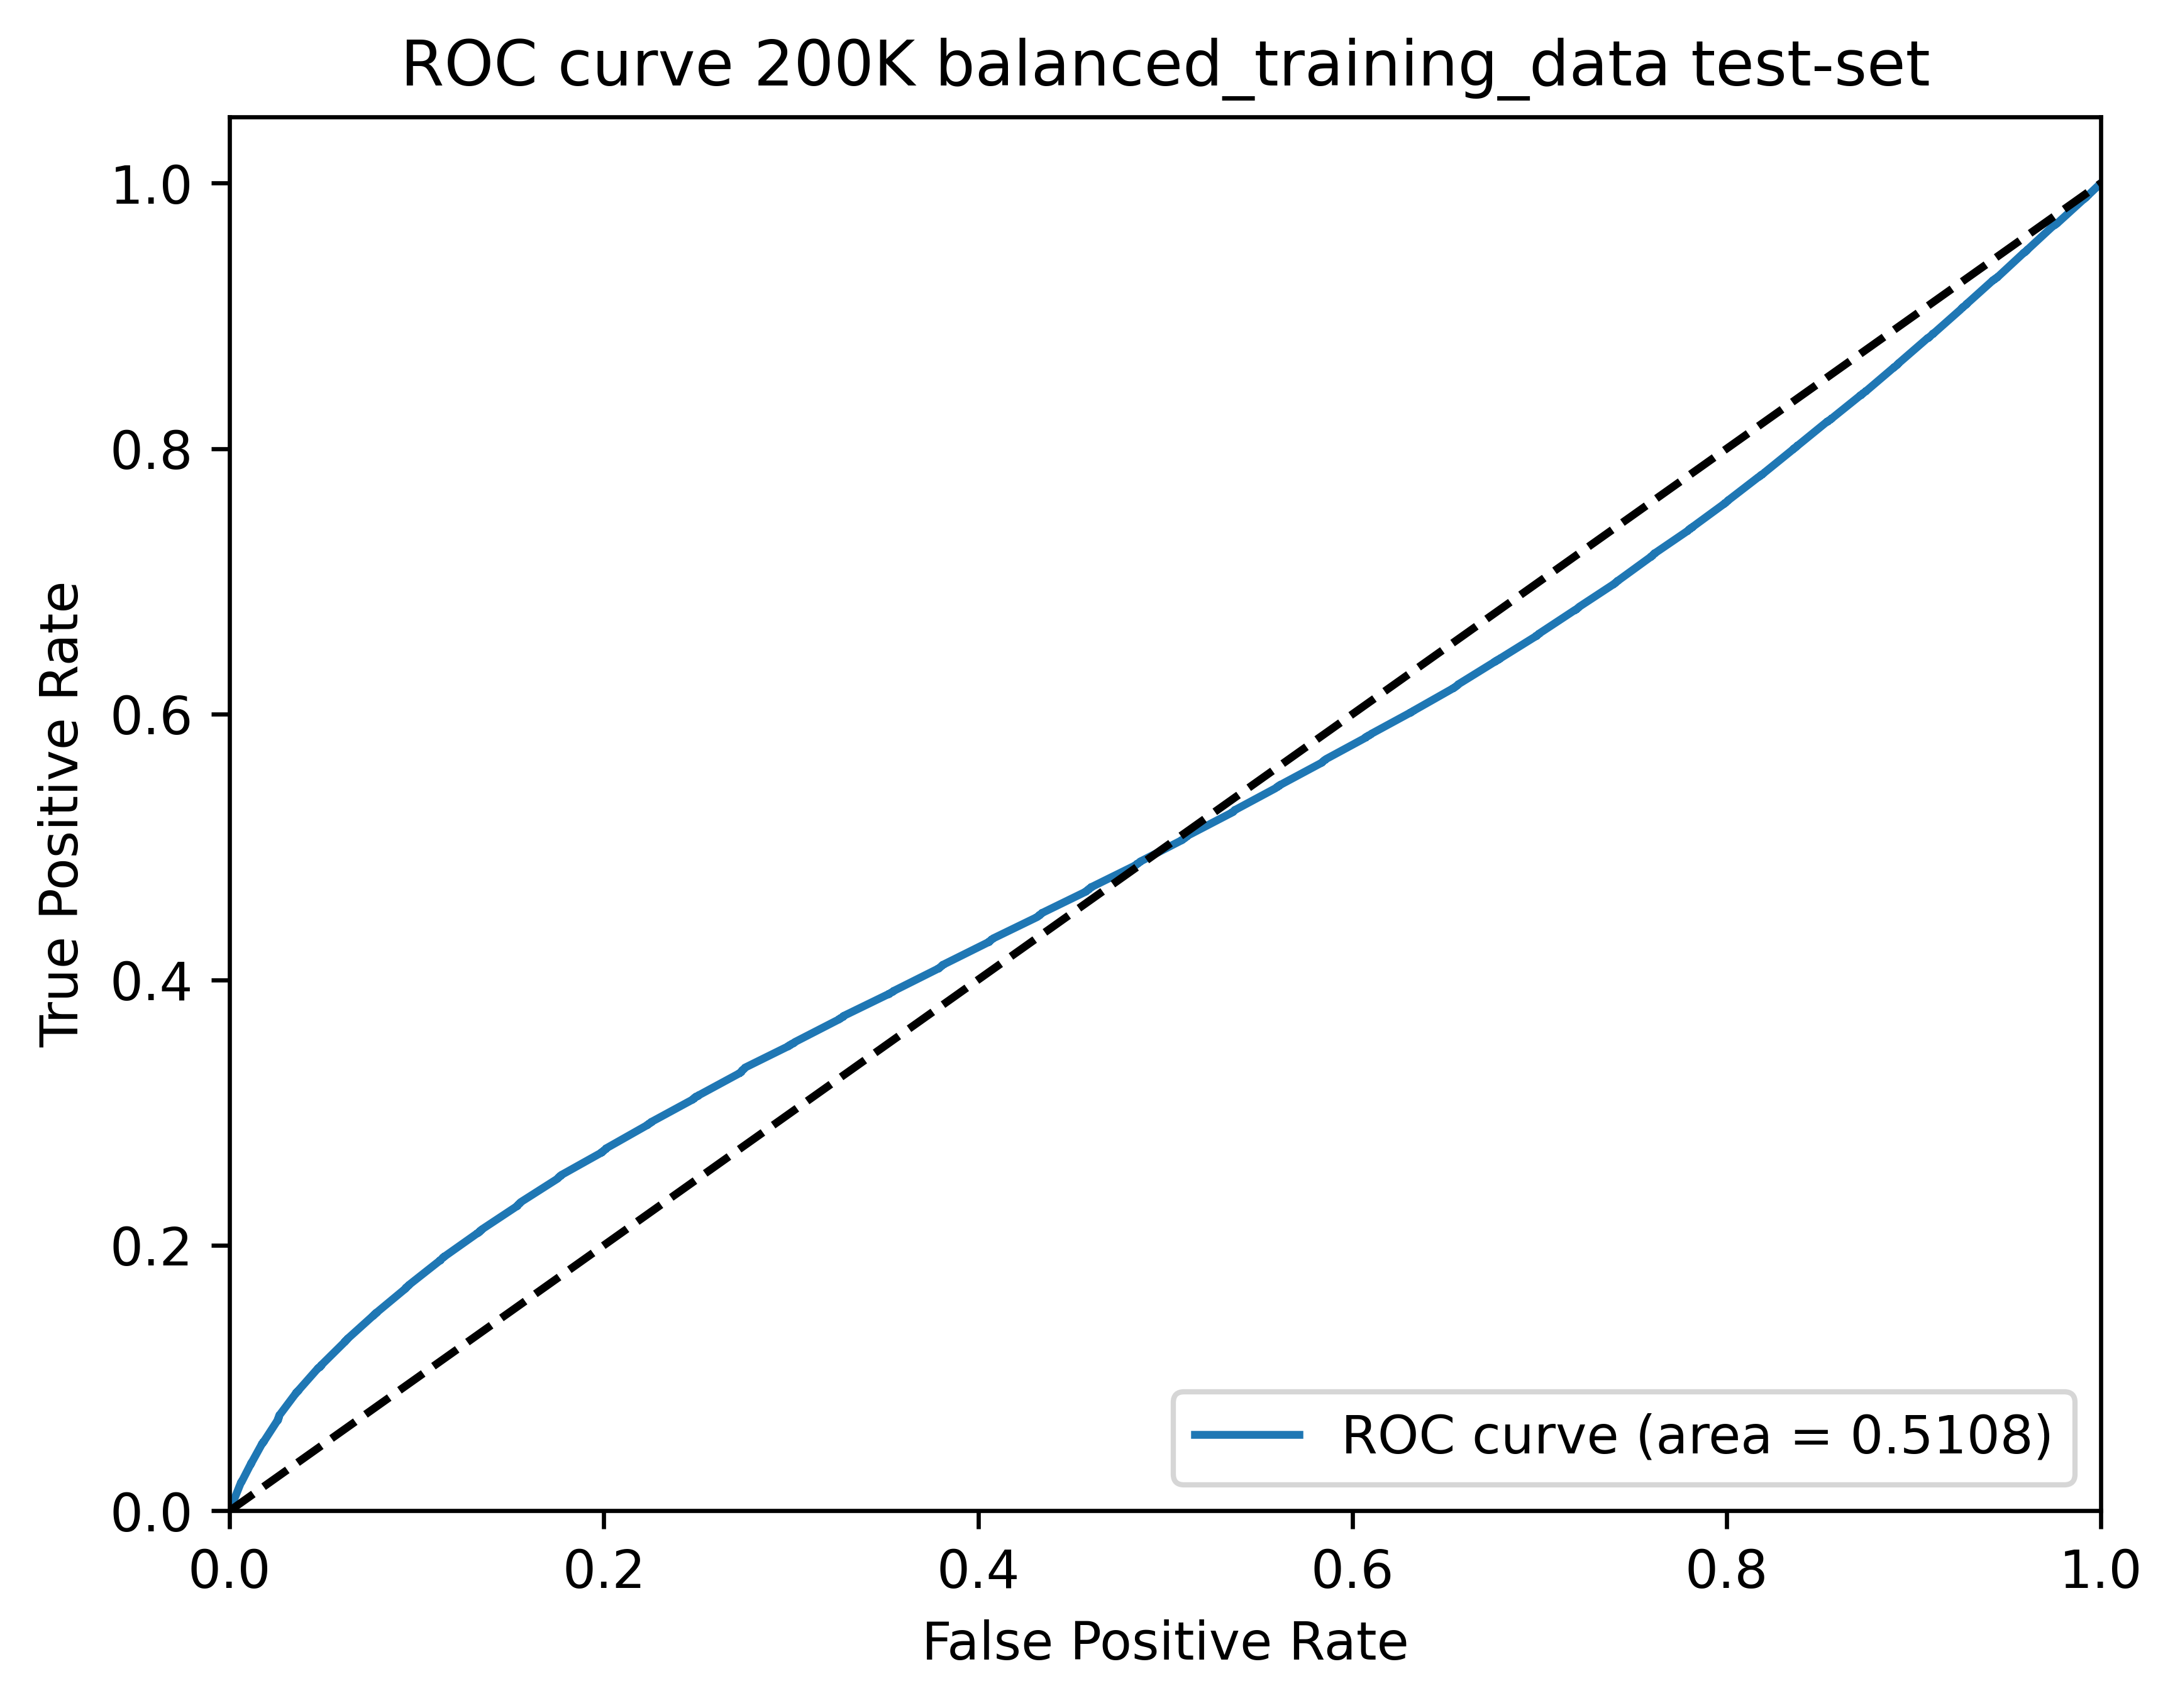

In [53]:
plot_roc_curve_binary(y_test, y_test_pred_prob, title='ROC curve 200K balanced_training_data test-set', save=False)

on validation set

In [54]:
y_valid_pred_prob_raw = pipeline_test.predict_proba(X_valid)

y_valid_pred = np.argmax(y_valid_pred_prob_raw, axis=1)

y_valid_pred_prob = y_valid_pred_prob_raw if len(np.unique(y_valid)) > 2 \
                else np.array([y_valid_pred_prob_raw[i, pred] for i, pred in enumerate(list(y_valid_pred))])

In [55]:
print_classification_report(y_valid, y_valid_pred)

Classification report: 
               precision    recall  f1-score   support

           0       0.44      0.84      0.58    150369
           1       0.96      0.79      0.87    774937

    accuracy                           0.80    925306
   macro avg       0.70      0.82      0.73    925306
weighted avg       0.88      0.80      0.82    925306



TN - True Negative 126887
FN - False Negative 159829
TP - True Positive 615108
FP - False Positive 23482
Accuracy Rate: 0.8018914823852866
Misclassification Rate: 0.1981085176147134
F1-Score: 0.7254610970405935
ROC-AUC 0.8187948797067841


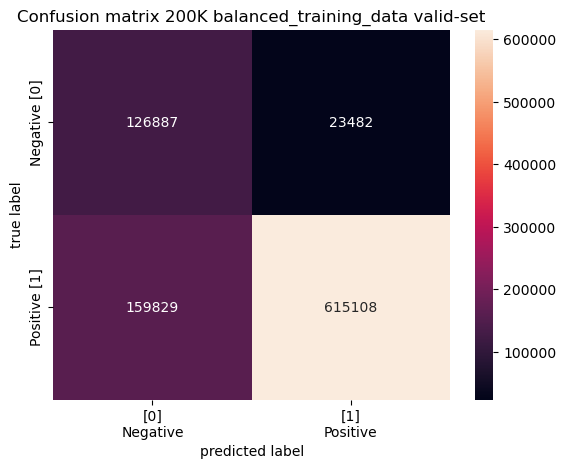

In [56]:
create_confusion_matrix_graph(y_valid, y_valid_pred, 'Confusion matrix 200K balanced_training_data valid-set', save=False)

In [ ]:
plot_roc_curve_binary(y_valid, y_valid_pred_prob, title='ROC curve 200K balanced_training_data valid-set', save=False)